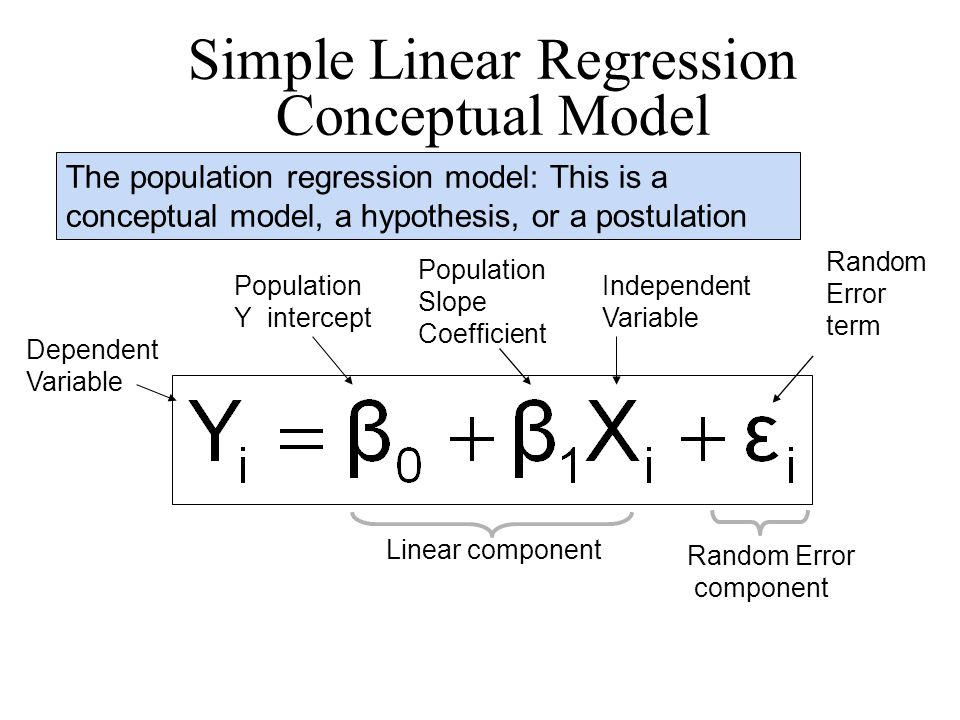

In [1]:
import os
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd

from pyspark.ml.feature import HashingTF, IDF, Tokenizer
import pickle  

In [2]:
## define a set of path: 
PATH = os.path.dirname(os.getcwd()) 
dataset_path = os.path.join(PATH, "dataset")
models_path = os.path.join(PATH, "models")

In [3]:
def load_data():
    data_path = os.path.join(dataset_path, "all_data.xlsx")
    data = pd.read_excel(data_path) 
    data_labels = data["labels"]  #Taking lables in separate
    print("data loaded")
    return data, data_labels

def tfidf(data):
    # corpus = pd.DataFrame({"reviews": train_data["reviews"], "lables": train_data["lables"]})
    # corpus.reviews.append(test_data["reviews"], ignore_index=True)
    corpus = data.copy()
    dataset = spark.createDataFrame(corpus, list(corpus.columns))

    tokenizer = Tokenizer(inputCol="reviews", outputCol="words")
    wordsData = tokenizer.transform(dataset)

    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
    featurizedData = hashingTF.transform(wordsData)

    idf = IDF(inputCol="rawFeatures", outputCol="features")
    idfModel = idf.fit(featurizedData)
    rescaledData = idfModel.transform(featurizedData)
    features = rescaledData.select("features","labels")
    #save model 
    tfidf = os.path.join(models_path, "tfidf.pickle")
    pickle.dump(tfidf, open(tfidf, "wb"))
    print("tfidf model saved")
    return idfModel, features

def plot_score(model, x,y, x_label='params', y_label='score'):
    plt.figure(figsize=(9, 9))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x, y)
    title = 'result of learning using  {}'.format(model)
    plt.suptitle(title)
    plt.show()
    
def plot_score2(x_axis, y1, y2,title, xlabels, ylabels, y1title="training curve",y2title="testing curve",y1color='r',y2color='g'):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabels)
    plt.ylabel(ylabels)
    plt.grid()
    plt.plot(x_axis, y1, 'o-', color=y1color, label= y1title)
    plt.plot(x_axis, y2, 'o-', color=y2color, label=y2title)
    plt.legend(loc="best")
    plt.show()

def plot_score3(x_axis, scores_train, title, xlabels, ylabels, ytitle="training score", y2color='g'):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabels)
    plt.ylabel(ylabels)
    plt.grid()
    plt.plot(x_axis, scores_train, 'o-', color=y2color, label= ytitle)
    #plt.plot(x_axis, scores_test, 'o-', color=y2color, label=y2title)
    plt.legend(loc="best")
    plt.show()

In [4]:
data, data_labels = load_data()
idfModel, features= tfidf(data)
features.show() 

data loaded
tfidf model saved
+--------------------+------+
|            features|labels|
+--------------------+------+
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,2,3,4,5,6,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,2,3,4,5,6,...|     1|
|(20,[0,2,3,4,5,6,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,6,...|     1|
|(20,[0,3,4,6,7,8,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
+--------------------+------+
only showing top 20 rows



In [5]:
from pyspark.ml.feature import VectorAssembler , StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.mllib.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

In [6]:
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True, 
    withStd= True
    ).fit(features)

df_scaled = scaler.transform(features)
df_scaled.show(5)

+--------------------+------+--------------------+
|            features|labels|      scaledFeatures|
+--------------------+------+--------------------+
|(20,[0,1,2,3,4,5,...|     1|[-0.5050488895147...|
|(20,[0,1,2,3,4,5,...|     1|[0.62957021237823...|
|(20,[0,1,2,3,4,5,...|     1|[-0.0187835601320...|
|(20,[0,1,2,3,4,5,...|     1|[-0.8292257757698...|
|(20,[0,1,2,3,4,5,...|     1|[-0.5050488895147...|
+--------------------+------+--------------------+
only showing top 5 rows



In [7]:
result_pdf = df_scaled.select('scaledFeatures').toPandas().rename(columns={"scaledFeatures": "features"})
#result_pdf.head()
transformed = result_pdf.join(df_scaled.select('labels').toPandas())
#transformed.head()
transformed = spark.createDataFrame(transformed, list(transformed.columns))
transformed.show(5)

+--------------------+------+
|            features|labels|
+--------------------+------+
|[-0.5050488895147...|     1|
|[0.62957021237823...|     1|
|[-0.0187835601320...|     1|
|[-0.8292257757698...|     1|
|[-0.5050488895147...|     1|
+--------------------+------+
only showing top 5 rows



In [8]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='labels',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)


+--------------------+------+------------+
|            features|labels|indexedLabel|
+--------------------+------+------------+
|[-0.5050488895147...|     1|         1.0|
|[0.62957021237823...|     1|         1.0|
|[-0.0187835601320...|     1|         1.0|
|[-0.8292257757698...|     1|         1.0|
|[-0.5050488895147...|     1|         1.0|
+--------------------+------+------------+
only showing top 5 rows



In [9]:
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)

+--------------------+------+--------------------+
|            features|labels|     indexedFeatures|
+--------------------+------+--------------------+
|[-0.5050488895147...|     1|[-0.5050488895147...|
|[0.62957021237823...|     1|[0.62957021237823...|
|[-0.0187835601320...|     1|[-0.0187835601320...|
|[-0.8292257757698...|     1|[-0.8292257757698...|
|[-0.5050488895147...|     1|[-0.5050488895147...|
+--------------------+------+--------------------+
only showing top 5 rows



In [10]:
#spliting training and testing data + training
(trainingData, testData) = transformed.randomSplit([0.8, 0.2])
print("training data")
trainingData.show(5,True)
print("testing data")
testData.show(5,True)

training data
+--------------------+------+
|            features|labels|
+--------------------+------+
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
+--------------------+------+
only showing top 5 rows

testing data
+--------------------+------+
|            features|labels|
+--------------------+------+
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
+--------------------+------+
only showing top 5 rows



In [12]:
#@title random forest  model
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=labelIndexer.labels)

# training and evaluation

In [26]:
#@title trainig and evaluation
regParam=0.01 #@param {type:"number"} #default step: 0.3
elasticNetParam=0.1 #@param {type:"number"} #default step: 0.8
maxIter = 1000 #@param {type:"integer"} 

model=LinearRegression(featuresCol='features', labelCol='labels', maxIter=maxIter, regParam=regParam, elasticNetParam=elasticNetParam)
lr_model = model.fit(trainingData)

prediction = lr_model.transform(testData)
binEval_test = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("labels")
accuracy_testing= binEval_test.evaluate(prediction)
#print("accuarcy: ",accuracy_testing)
print("coefficients: ",lr_model.coefficients)
print("intercept: ",lr_model.intercept)
pred_results=lr_model.evaluate(testData)
pred_results.predictions.show(40)


coefficients:  [-0.004204744287928956,0.04926642489403046,-0.00013660410122085634,-0.01431754702886746,-0.029326317912348347,-0.04910166065738052,-0.07030251384375127,0.009644347271950264,-0.004476481974312145,0.013294387913239333,0.05381256050319025,-0.012325868443550556,-0.025053898417479563,0.024592689017200107,-0.05641136806442229,0.04901228639214103,-0.030200990601046498,0.08075769279641969,0.028749286522138526,0.0]
intercept:  0.4982660063612233
+--------------------+------+-------------------+
|            features|labels|         prediction|
+--------------------+------+-------------------+
|[-1.1534026620249...|     1| 0.5230535860826724|
|[-1.1534026620249...|     1| 0.4769508137494424|
|[-1.1534026620249...|     1| 0.4823689383756451|
|[-1.1534026620249...|     1| 0.5296437817985549|
|[-1.1534026620249...|     1| 0.4469968962384876|
|[-1.1534026620249...|     1| 0.5711485513442693|
|[-1.1534026620249...|     1|0.47322523260457416|
|[-1.1534026620249...|     1| 0.366585854610

In [15]:
#@title save model 
linear_regression_path = os.path.join(models_path, "linear_regression")

try:
    lr_model.save(linear_regression_path)
    sameModel = LinearRegressionModel.load(linear_regression_path)
except:
    pass